In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kendalltau
import seaborn as sns
from networkx.algorithms import community

In [2]:
disruptions = pd.read_csv(r'C:\Users\Hithen\OneDrive\Desktop\230230204DissertationFinal\Dataset\disruptions.csv')
nodes = pd.read_csv(r'C:\Users\Hithen\OneDrive\Desktop\230230204DissertationFinal\Dataset\nodes.csv')
layers = pd.read_csv(r'C:\Users\Hithen\OneDrive\Desktop\230230204DissertationFinal\Dataset\layers.csv')
edges = pd.read_csv(r'C:\Users\Hithen\OneDrive\Desktop\230230204DissertationFinal\Dataset\edges.csv')

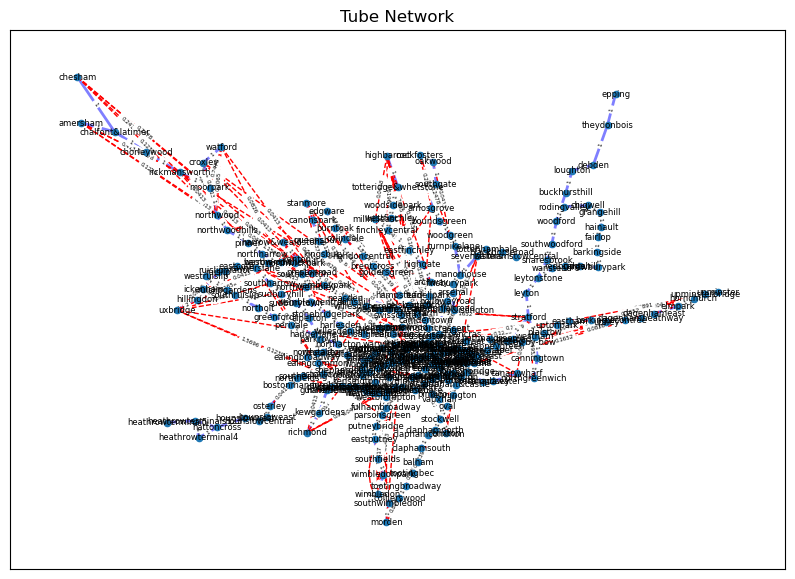

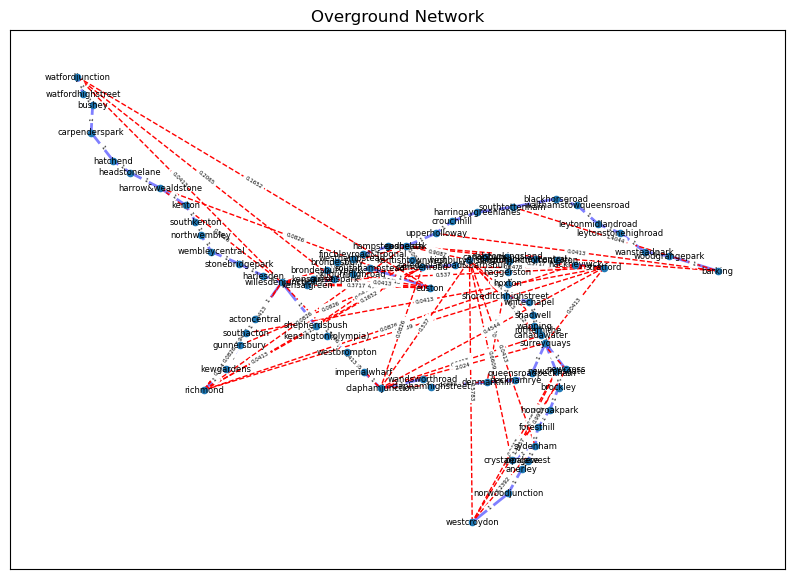

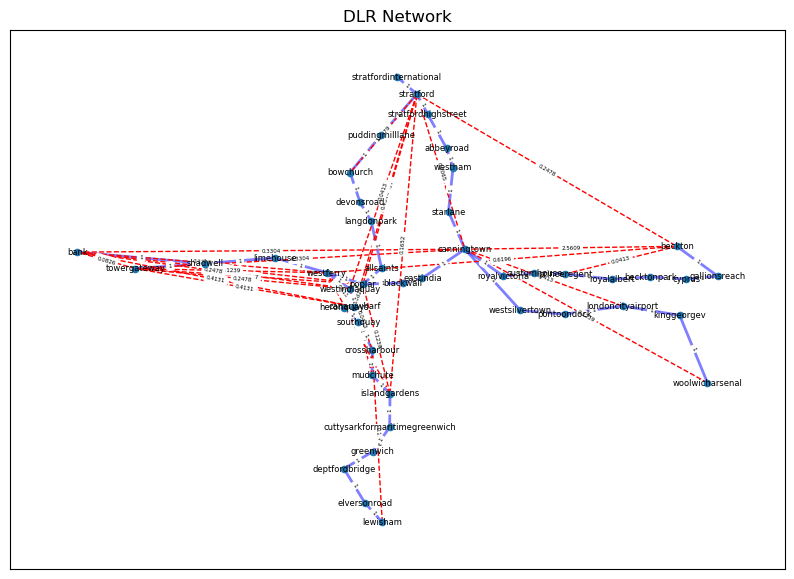

In [3]:
layer_mapping = layers.set_index('layerID')['layerLabel'].to_dict()
node_mapping = nodes.set_index('nodeID')['nodeLabel'].to_dict()

# Initialize graphs for each layer
graphs = {
    'Tube': nx.Graph(),
    'Overground': nx.Graph(),
    'DLR': nx.Graph()
}

# Function to classify the layer
def classify_layer(layer_name):
    if layer_name.lower() in ['tube', 'metropolitan', 'jubilee', 'bakerloo', 'central', 'circle', 'district', 'hammersmith&city', 'northern', 'piccadilly', 'victoria', 'waterloo&city']:
        return 'Tube'
    elif layer_name.lower() == 'overground':
        return 'Overground'
    elif layer_name.lower() == 'dlr':
        return 'DLR'
    else:
        return None

# Add nodes to the graphs
for _, row in nodes.iterrows():
    node_label = row['nodeLabel']
    node_pos = (row['nodeLong'], row['nodeLat'])
    for graph in graphs.values():
        graph.add_node(node_label, pos=node_pos)

# Add edges from disruptions CSV
for _, row in disruptions.iterrows():
    layer = classify_layer(row['LAYER'])
    if layer:
        station_a = row['STATION_A']
        station_b = row['STATION_B']
        weight = row['FREQUENCY%']
        graphs[layer].add_edge(station_a, station_b, weight=weight, disruption=True)

# Add edges from edges CSV
for _, row in edges.iterrows():
    layer_id = row['layerID']
    node_a = node_mapping.get(row['nodeID1'])
    node_b = node_mapping.get(row['nodeID2'])
    weight = row['weight']
    
    layer = layer_mapping.get(layer_id)
    if layer and node_a and node_b:
        graphs[layer].add_edge(node_a, node_b, weight=weight, disruption=False)

# Remove isolated nodes and unnecessary nodes
for layer, graph in graphs.items():
    # Get nodes with at least one edge
    nodes_with_edges = set(graph.nodes) - set(nx.isolates(graph))
    # Create subgraph with relevant nodes
    subgraph = graph.subgraph(nodes_with_edges).copy()
    graphs[layer] = subgraph

# Function to visualize the graph
def visualize_graph(graph, title, filename):
    pos = nx.get_node_attributes(graph, 'pos')
    
    # Separate edges into disruption and regular
    edges_disruption = [(u, v) for u, v, data in graph.edges(data=True) if data.get('disruption', False)]
    edges_regular = [(u, v) for u, v, data in graph.edges(data=True) if not data.get('disruption', False)]
    
    plt.figure(figsize=(10, 7))
    ax = plt.gca()
    
    # Draw nodes
    nx.draw_networkx_nodes(graph, pos, node_size=20)
    nx.draw_networkx_edges(graph, pos, edgelist=edges_regular, width=2, alpha=0.5, edge_color='blue', ax=ax)
    nx.draw_networkx_edges(graph, pos, edgelist=edges_disruption, width=1, edge_color='red', style='dashed', ax=ax)
    
    # Draw labels
    nx.draw_networkx_labels(graph, pos, font_size=6, ax=ax)
    
    # Draw edge labels with smaller font size
    edge_labels = nx.get_edge_attributes(graph, 'weight')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=4, ax=ax)
    
    plt.title(title)
    plt.savefig(filename, format='png')
    plt.show()

# Visualize each graph
for layer, graph in graphs.items():
    visualize_graph(graph, f"{layer} Network", f"{layer}_network.png")

C:\Users\Hithen\AppData\Local\Temp\ipykernel_18656\4187865983.py:5: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(graph).todense()


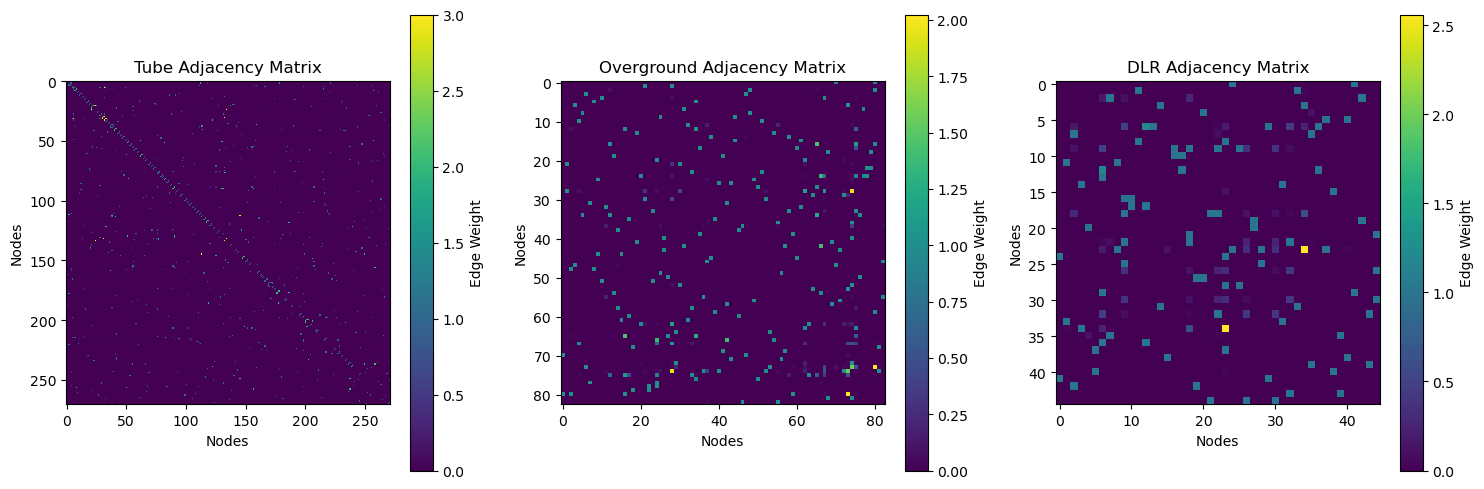

In [4]:

plt.figure(figsize=(15, 5))

for i, (layer, graph) in enumerate(graphs.items()):
    plt.subplot(1, 3, i + 1)
    adj_matrix = nx.adjacency_matrix(graph).todense()
    plt.imshow(adj_matrix, cmap='viridis', interpolation='nearest')
    plt.title(f"{layer} Adjacency Matrix")
    plt.colorbar(label='Edge Weight')
    plt.xlabel('Nodes')
    plt.ylabel('Nodes')

plt.tight_layout()
plt.savefig("adjacency_matrix.png")
plt.show()

Network Layer: Tube
Highest Degree Nodes: wembleypark, bakerstreet, earlscourt
Clustering Coefficient: 0.1264
Network Density: 0.0141
Assortativity: 0.2544

Network Layer: Overground
Highest Degree Nodes: willesdenjunction, highbury&islington, claphamjunction
Clustering Coefficient: 0.1645
Network Density: 0.0420
Assortativity: 0.2451

Network Layer: DLR
Highest Degree Nodes: stratford, canningtown, poplar
Clustering Coefficient: 0.1246
Network Density: 0.0768
Assortativity: 0.2693



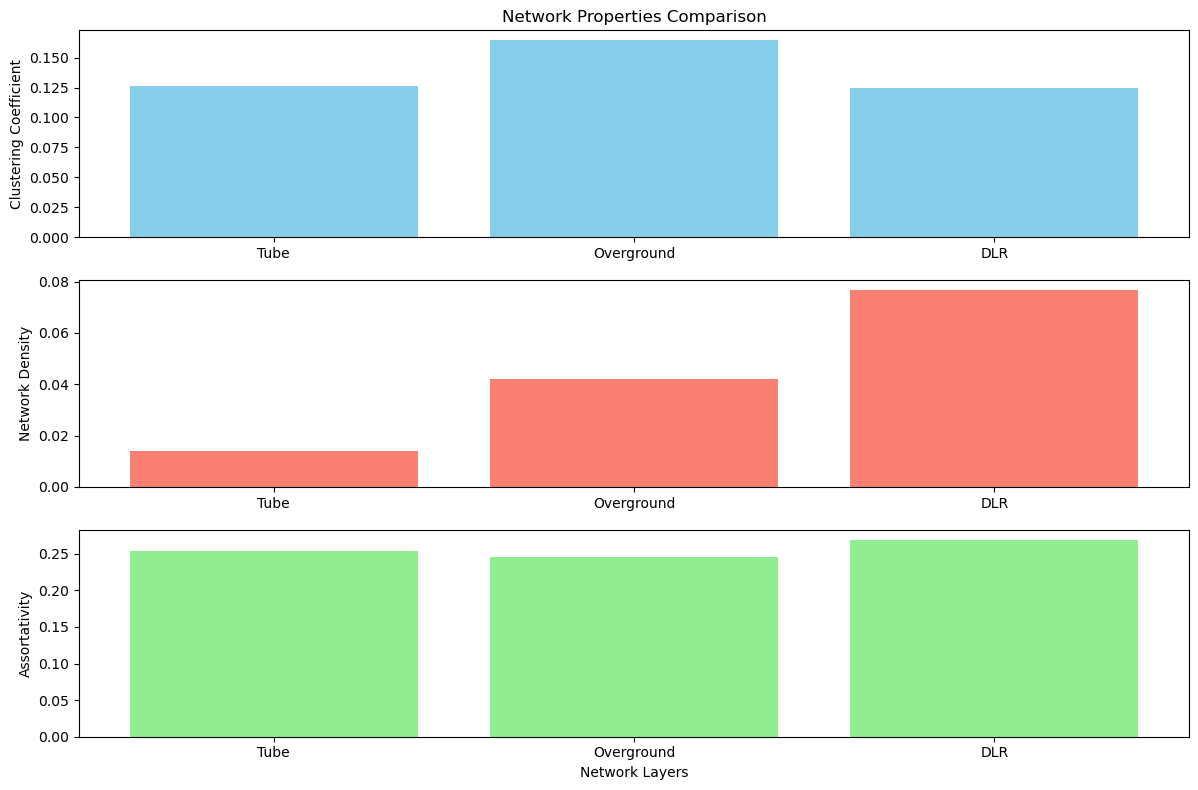

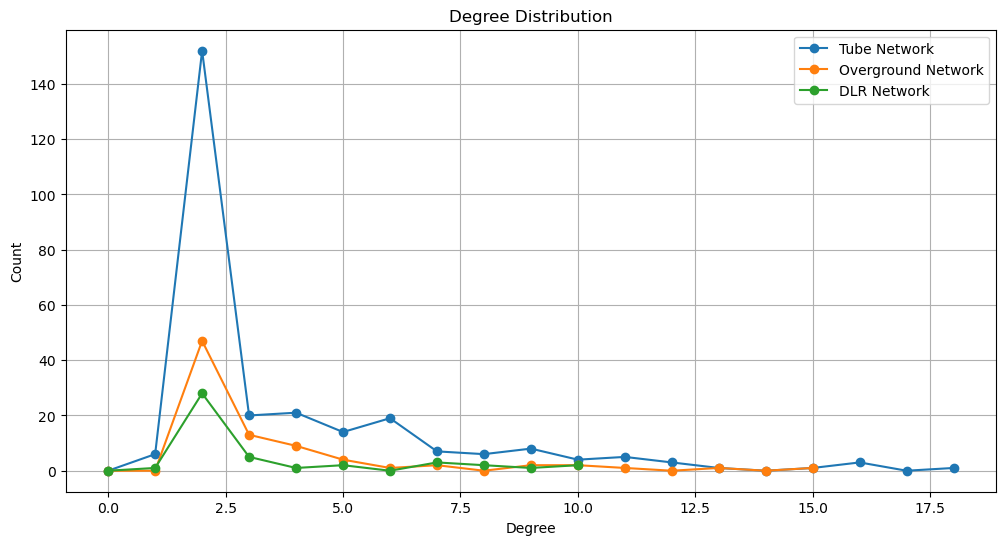

In [5]:
results = {}

for layer, graph in graphs.items():
    # Degree Distribution
    degree_sequence = sorted([(n, d) for n, d in graph.degree()], key=lambda x: x[1], reverse=True)
    top_nodes = degree_sequence[:3]
    top_node_names = [node for node, _ in top_nodes]
    results[layer] = {'Top Nodes by Degree': top_node_names}

    # Clustering Coefficient
    clustering_coefficient = nx.average_clustering(graph)
    results[layer]['Clustering Coefficient'] = clustering_coefficient

    # Network Density
    density = nx.density(graph)
    results[layer]['Network Density'] = density

    # Assortativity
    assortativity = nx.degree_assortativity_coefficient(graph)
    results[layer]['Assortativity'] = assortativity

# Print network properties
for layer, data in results.items():
    print(f"Network Layer: {layer}")
    print(f"Highest Degree Nodes: {', '.join(data['Top Nodes by Degree'])}")
    print(f"Clustering Coefficient: {data['Clustering Coefficient']:.4f}")
    print(f"Network Density: {data['Network Density']:.4f}")
    print(f"Assortativity: {data['Assortativity']:.4f}")
    print()

# Prepare data for bar plots
properties = ['Clustering Coefficient', 'Network Density', 'Assortativity']
data = {prop: [results[layer][prop] for layer in graphs.keys()] for prop in properties}
labels = list(graphs.keys())

# Plot network properties comparison
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.bar(labels, data['Clustering Coefficient'], color='skyblue')
plt.ylabel('Clustering Coefficient')
plt.title('Network Properties Comparison')

plt.subplot(3, 1, 2)
plt.bar(labels, data['Network Density'], color='salmon')
plt.ylabel('Network Density')

plt.subplot(3, 1, 3)
plt.bar(labels, data['Assortativity'], color='lightgreen')
plt.ylabel('Assortativity')
plt.xlabel('Network Layers')

plt.tight_layout()
plt.savefig("measure.png")
plt.show()

# Plot degree distribution
plt.figure(figsize=(12, 6))
for layer in graphs.keys():
    degree_counts = np.bincount([d for _, d in graphs[layer].degree()])
    plt.plot(range(len(degree_counts)), degree_counts, marker='o', linestyle='-', label=f"{layer} Network")
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Degree Distribution')
plt.legend()
plt.grid(True)
plt.savefig("degree_distribution.png")
plt.show()

Network Layer: Tube
Average Path Length: 6.0677
Network Diameter: 22
Efficiency: 0.2135

Network Layer: Overground
Average Path Length: 4.2751
Network Diameter: 10
Efficiency: 0.2926

Network Layer: DLR
Average Path Length: 3.4525
Network Diameter: 8
Efficiency: 0.3614



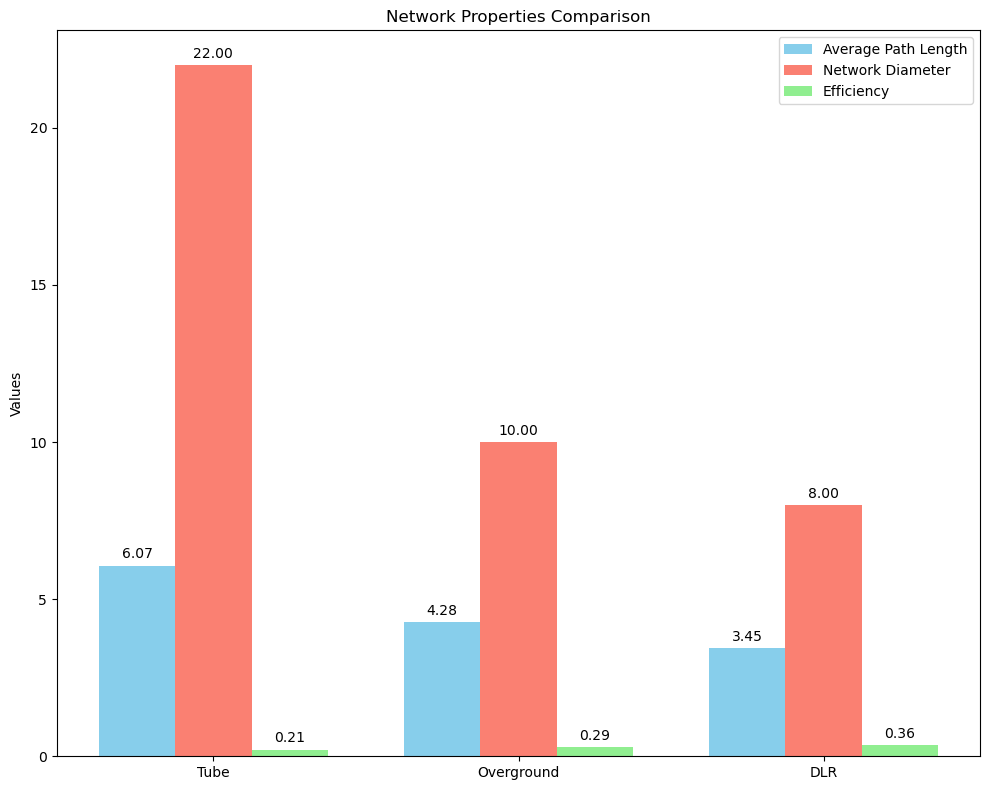

In [6]:
results = {}

for layer, graph in graphs.items():
    if nx.is_connected(graph):
        avg_path_length = nx.average_shortest_path_length(graph)
    else:
        avg_path_length = np.nan
    results[layer] = {'Average Path Length': avg_path_length}

    if nx.is_connected(graph):
        diameter = nx.diameter(graph)
    else:
        diameter = np.nan
    results[layer]['Network Diameter'] = diameter

    if nx.is_connected(graph):
        efficiency = nx.global_efficiency(graph)
    else:
        efficiency = np.nan
    results[layer]['Efficiency'] = efficiency

for layer, data in results.items():
    print(f"Network Layer: {layer}")
    print(f"Average Path Length: {data['Average Path Length']:.4f}")
    print(f"Network Diameter: {data['Network Diameter']}")
    print(f"Efficiency: {data['Efficiency']:.4f}")
    print()

labels = list(graphs.keys())
avg_path_lengths = [results[layer]['Average Path Length'] if layer in results else np.nan for layer in labels]
network_diameters = [results[layer]['Network Diameter'] if layer in results else np.nan for layer in labels]
efficiencies = [results[layer]['Efficiency'] if layer in results else np.nan for layer in labels]


x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 8))

rects1 = ax.bar(x - width, avg_path_lengths, width, label='Average Path Length', color='skyblue')

rects2 = ax.bar(x, network_diameters, width, label='Network Diameter', color='salmon')
rects3 = ax.bar(x + width, efficiencies, width, label='Efficiency', color='lightgreen')

ax.set_ylabel('Values')
ax.set_title('Network Properties Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.savefig("props")
plt.show()

Top 1 Degree Centrality Graph with 271 nodes and 312 edges: bakerstreet - 0.0259
Top 2 Degree Centrality Graph with 271 nodes and 312 edges: kingscrossstpancras - 0.0259
Top 3 Degree Centrality Graph with 271 nodes and 312 edges: earlscourt - 0.0222
Top 1 Degree Centrality Graph with 83 nodes and 83 edges: willesdenjunction - 0.0610
Top 2 Degree Centrality Graph with 83 nodes and 83 edges: surreyquays - 0.0488
Top 3 Degree Centrality Graph with 83 nodes and 83 edges: gospeloak - 0.0366
Top 1 Degree Centrality Graph with 45 nodes and 46 edges: poplar - 0.0909
Top 2 Degree Centrality Graph with 45 nodes and 46 edges: canningtown - 0.0909
Top 3 Degree Centrality Graph with 45 nodes and 46 edges: stratford - 0.0682


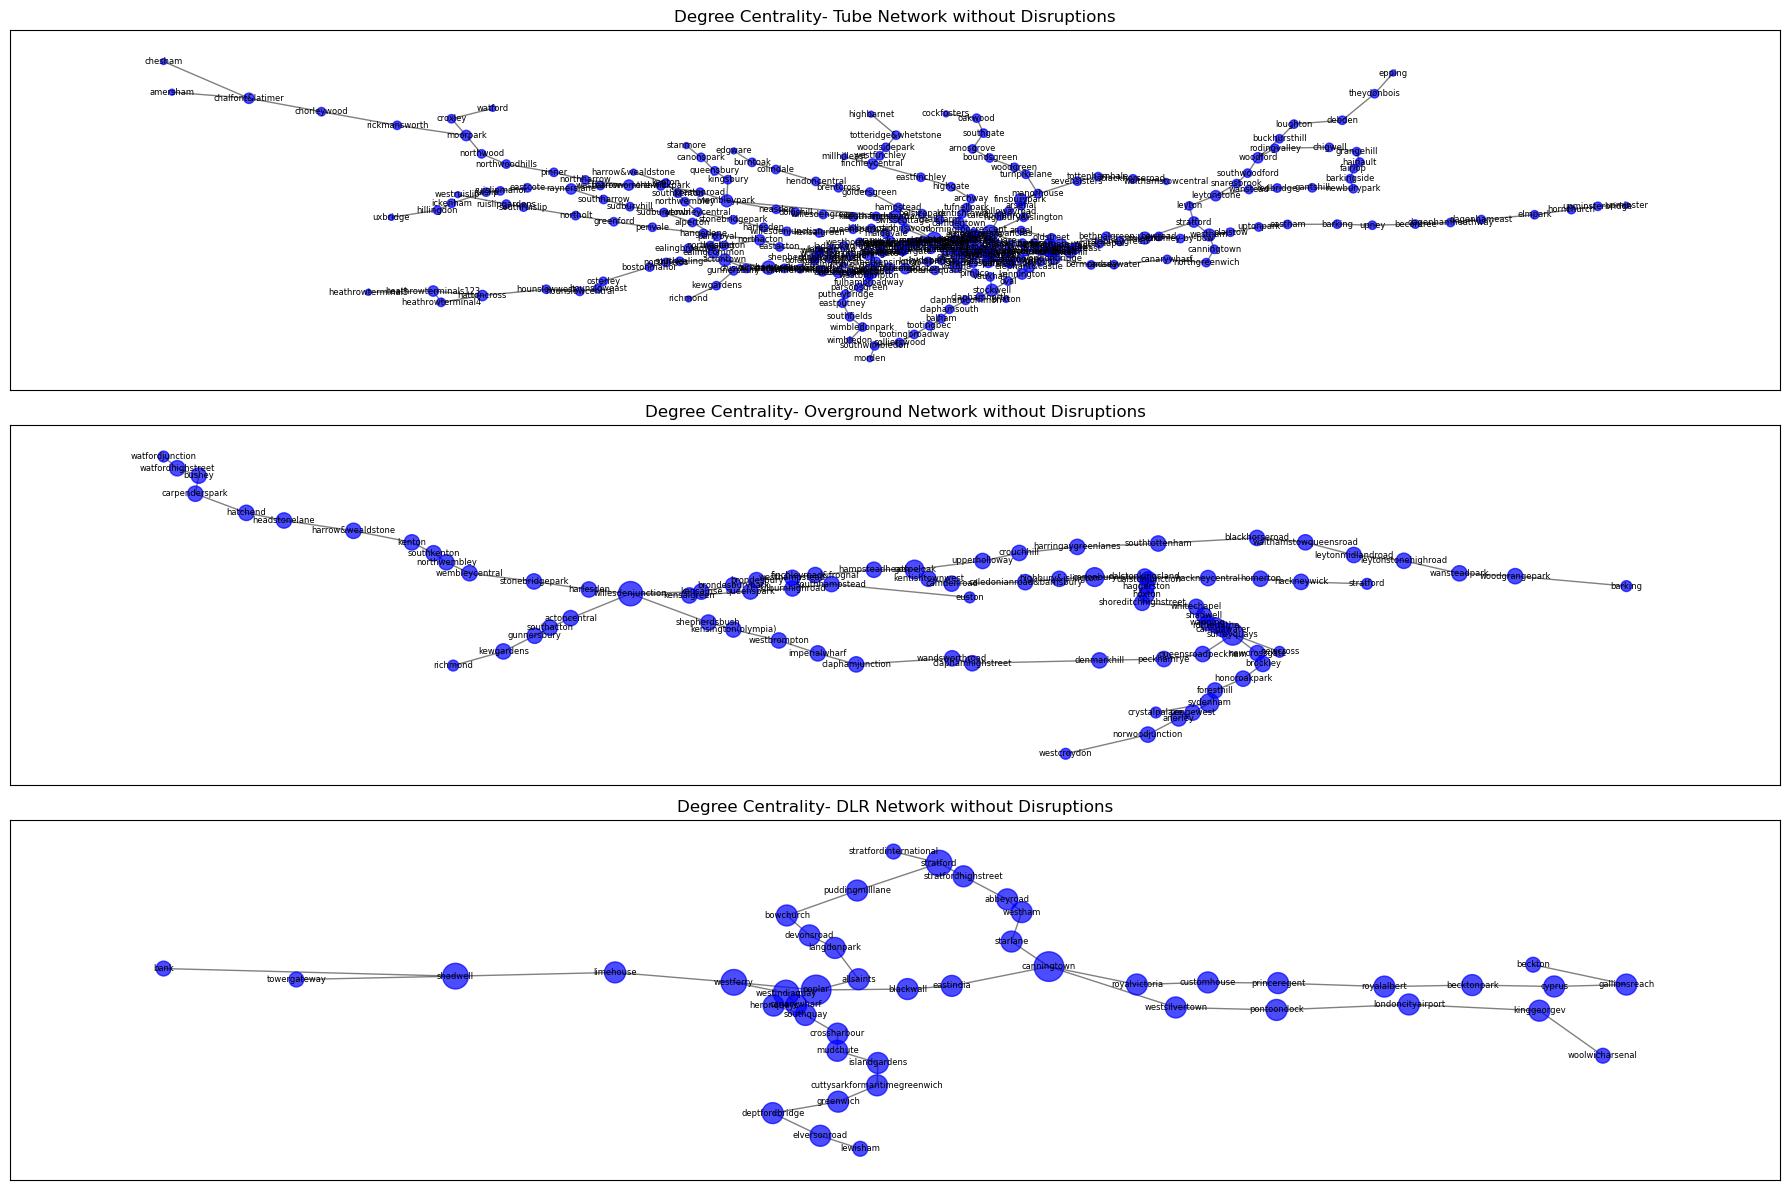

Top 1 Betweenness Centrality Graph with 271 nodes and 312 edges: bakerstreet - 0.3574
Top 2 Betweenness Centrality Graph with 271 nodes and 312 edges: greenpark - 0.3385
Top 3 Betweenness Centrality Graph with 271 nodes and 312 edges: liverpoolstreet - 0.2732
Top 1 Betweenness Centrality Graph with 83 nodes and 83 edges: willesdenjunction - 0.5438
Top 2 Betweenness Centrality Graph with 83 nodes and 83 edges: gospeloak - 0.3881
Top 3 Betweenness Centrality Graph with 83 nodes and 83 edges: surreyquays - 0.3213
Top 1 Betweenness Centrality Graph with 45 nodes and 46 edges: poplar - 0.5529
Top 2 Betweenness Centrality Graph with 45 nodes and 46 edges: canningtown - 0.5518
Top 3 Betweenness Centrality Graph with 45 nodes and 46 edges: blackwall - 0.4133


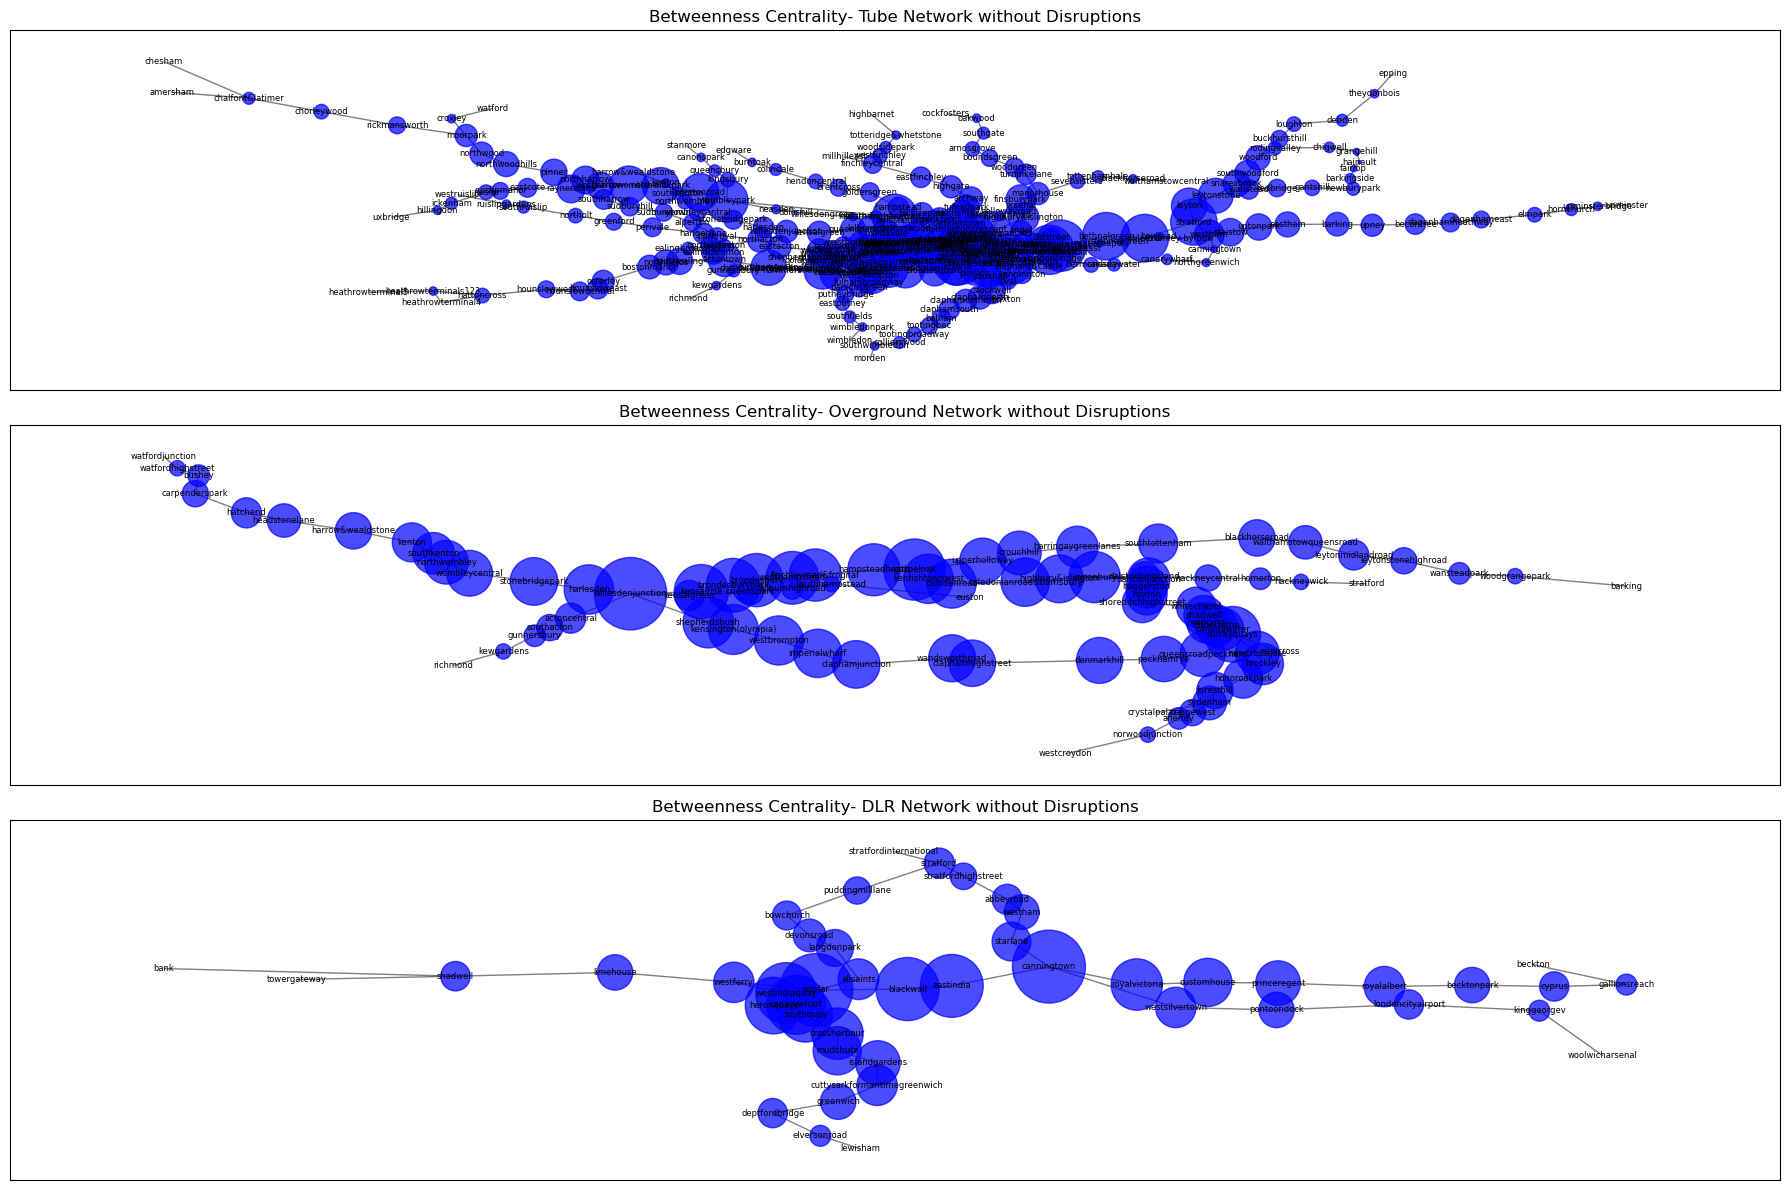

In [7]:

# Function to calculate centrality measures and print top 3 stations
def calculate_centrality(graph, measure):
    if measure == 'degree':
        centrality = nx.degree_centrality(graph)
    elif measure == 'betweenness':
        centrality = nx.betweenness_centrality(graph)
    else:
        raise ValueError("Invalid centrality measure. Choose 'degree' or 'betweenness'.")
    
    sorted_centrality = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
    top_3 = sorted_centrality[:3]
    for rank, (node, value) in enumerate(top_3, start=1):
        print(f"Top {rank} {measure.capitalize()} Centrality {graph}: {node} - {value:.4f}")
    
    return centrality


# Function to visualize the centrality measures for all layers
def plot_centrality(graphs, measure):
    plt.figure(figsize=(18, 12))
    for i, (layer, graph) in enumerate(graphs.items(), 1):
        plt.subplot(3, 1, i)
        pos = nx.get_node_attributes(graph, 'pos')
        
        title = f"{layer} Network without Disruptions"
        edges = [(u, v) for u, v, d in graph.edges(data=True) if not d.get('disruption', False)]
        
        subgraph = graph.edge_subgraph(edges).copy()
        centrality = calculate_centrality(subgraph, measure)
        
        node_sizes = [5000 * centrality[node] for node in subgraph.nodes()]
        nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, node_color='blue', alpha=0.7)
        nx.draw_networkx_edges(subgraph, pos, width=1, alpha=0.5)
        nx.draw_networkx_labels(subgraph, pos, font_size=6)
        
        plt.title(f'{measure.capitalize()} Centrality- {title}')
    
    plt.tight_layout()
    plt.savefig(f'{measure}_centrality_comparison_without_disruptions.png', format='png')
    plt.show()

# Plot centrality comparisons for each measure without disruptions
for measure in ['degree', 'betweenness']:
    plot_centrality(graphs, measure)


Network Layer: Tube
Community 1: regentspark, eastacton, marblearch, bakerstreet, queensway, ladbrokegrove, lancastergate, kenton, borough, edgwareroad(circleline), oxfordcircus, harrow&wealdstone, stonebridgepark, royaloak, marylebone, bondstreet, lambethnorth, elephant&castle, piccadillycircus, hammersmith(h&cline), northwembley, stjohnswood, shepherdsbushmarket, swisscottage, highstreetkensington, kilburnpark, westbournepark, shepherdsbush, woodlane, hollandpark, willesdenjunction, kensalgreen, maidavale, edgwareroad(districtline), paddington(h&cline), queenspark, latimerroad, edgwareroad(bakerlooline), warwickavenue, southkenton, goldhawkroad, harlesden, whitecity, nottinghillgate, bayswater, wembleycentral, paddington
Community 2: hillingdon, uxbridge, kewgardens, southealing, sudburytown, harrow-on-the-hill, osterley, northealing, ruislip, gunnersbury, baronscourt, southharrow, ickenham, sloanesquare, gloucesterroad, knightsbridge, westharrow, actontown, ealingcommon, richmond, r

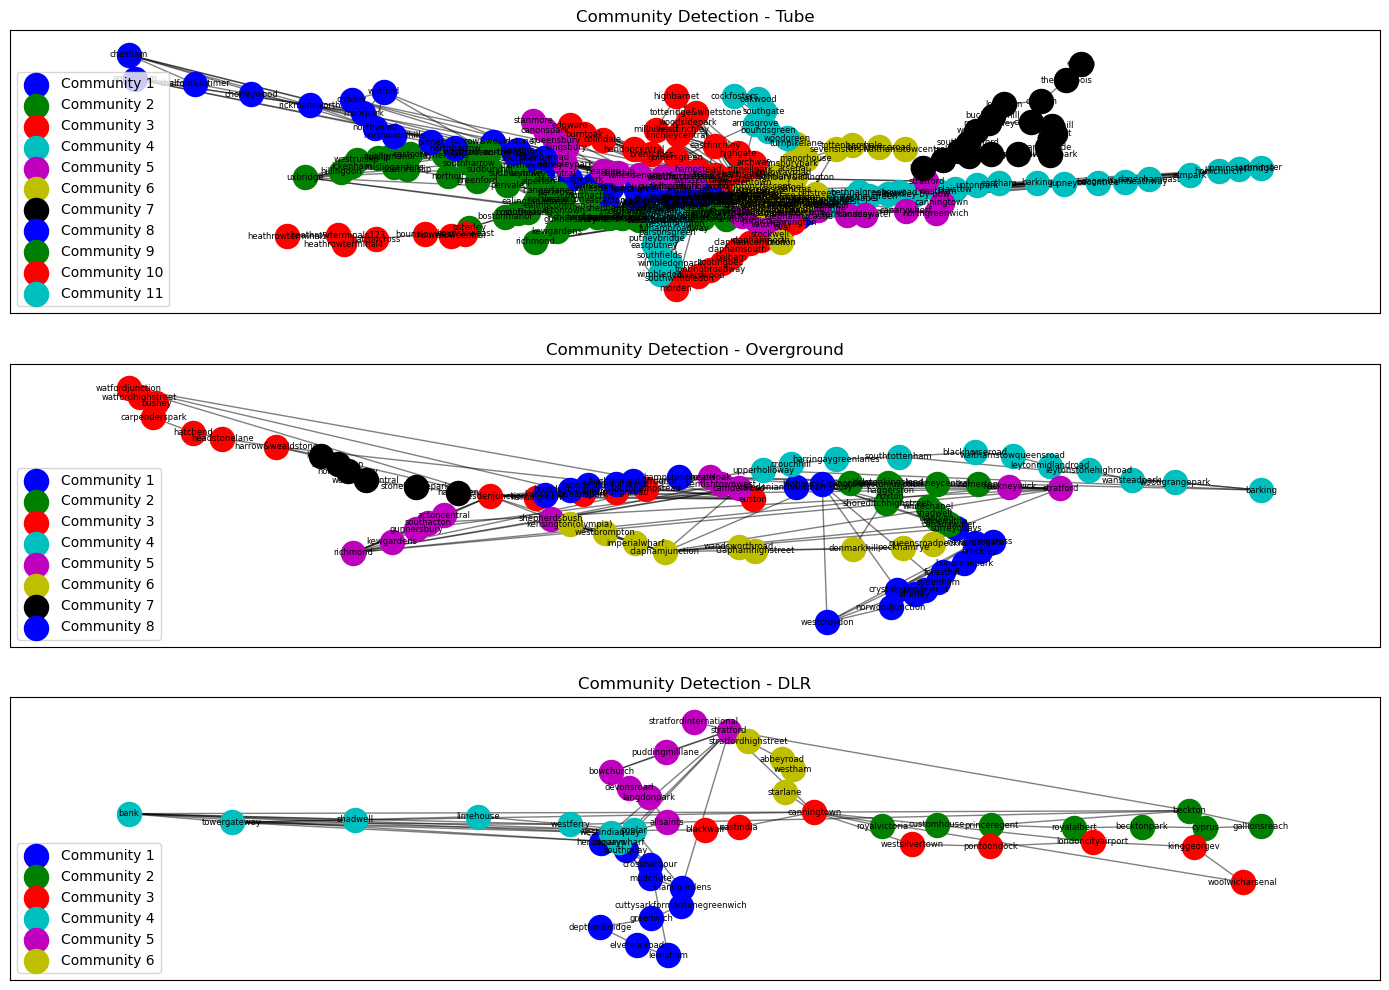

In [8]:
results = {}

for layer, graph in graphs.items():

    communities = list(community.greedy_modularity_communities(graph))
    results[layer] = {'Communities': communities}


for layer, data in results.items():
    print(f"Network Layer: {layer}")
    for i, community_nodes in enumerate(data['Communities']):
        print(f"Community {i + 1}: {', '.join(community_nodes)}")
    print()


plt.figure(figsize=(14, 10))

for i, (layer, data) in enumerate(results.items()):
    graph = graphs[layer]
    pos = nx.get_node_attributes(graph, 'pos')
    ax = plt.subplot(3, 1, i + 1)
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Adjust as needed for more communities
    for j, community_nodes in enumerate(data['Communities']):
        nx.draw_networkx_nodes(graph, pos, nodelist=community_nodes, node_color=colors[j % len(colors)], label=f"Community {j + 1}")
        nx.draw_networkx_labels(graph, pos, labels={node: node for node in community_nodes}, font_size=6)
    nx.draw_networkx_edges(graph, pos, alpha=0.5)
    plt.title(f"Community Detection - {layer}")
    plt.legend()
plt.savefig("comm")
plt.tight_layout()
plt.show()

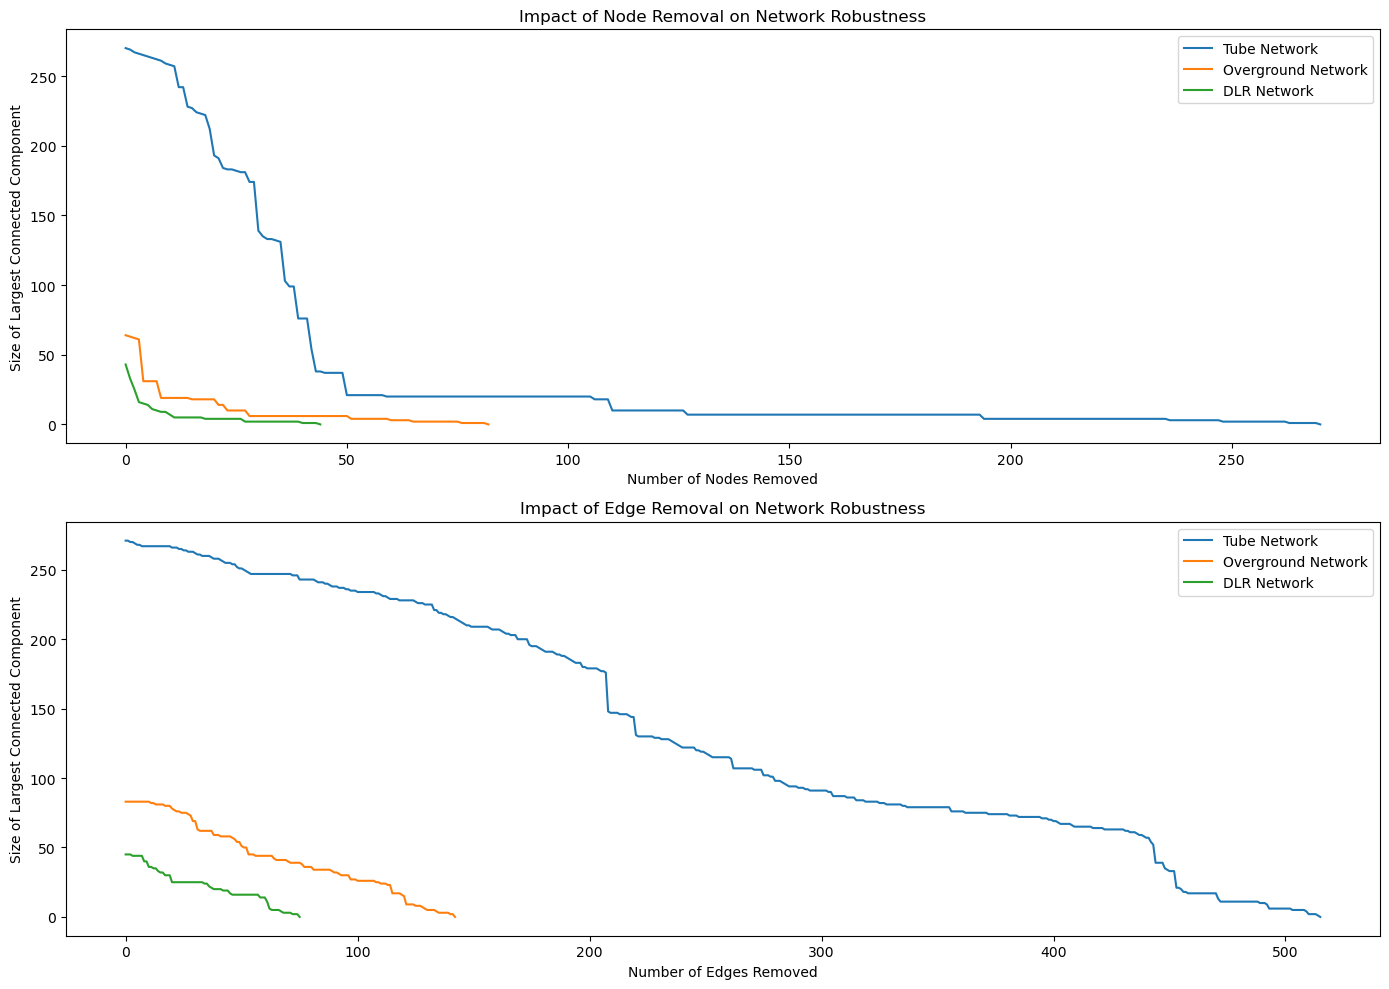

In [9]:
def simulate_node_removal(graph, removal_order):
    sizes_of_largest_component = []
    for node in removal_order:
        graph.remove_node(node)
        if len(graph.nodes) == 0:
            sizes_of_largest_component.append(0)
            break
        largest_component_size = len(max(nx.connected_components(graph), key=len))
        sizes_of_largest_component.append(largest_component_size)
    return sizes_of_largest_component

def simulate_edge_removal(graph, removal_order):
    sizes_of_largest_component = []
    for edge in removal_order:
        graph.remove_edge(*edge)
        if len(graph.edges) == 0:
            sizes_of_largest_component.append(0)
            break
        largest_component_size = len(max(nx.connected_components(graph), key=len))
        sizes_of_largest_component.append(largest_component_size)
    return sizes_of_largest_component


results_node_removal = {}
results_edge_removal = {}

for layer, graph in graphs.items():

    node_removal_graph = graph.copy()
    edge_removal_graph = graph.copy()


    degree_centrality = nx.degree_centrality(node_removal_graph)
    sorted_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)
    node_removal_result = simulate_node_removal(node_removal_graph, sorted_nodes)
    results_node_removal[layer] = node_removal_result

    # Edge Removal
    sorted_edges = sorted(edge_removal_graph.edges(data=True), key=lambda x: x[2].get('weight', 1), reverse=True)
    edge_removal_result = simulate_edge_removal(edge_removal_graph, [(u, v) for u, v, d in sorted_edges])
    results_edge_removal[layer] = edge_removal_result


plt.figure(figsize=(14, 10))


plt.subplot(2, 1, 1)
for layer, data in results_node_removal.items():
    plt.plot(data, label=f"{layer} Network")
plt.xlabel('Number of Nodes Removed')
plt.ylabel('Size of Largest Connected Component')
plt.title('Impact of Node Removal on Network Robustness')
plt.legend()

# Edge Removal Plot
plt.subplot(2, 1, 2)
for layer, data in results_edge_removal.items():
    plt.plot(data, label=f"{layer} Network")
plt.xlabel('Number of Edges Removed')
plt.ylabel('Size of Largest Connected Component')
plt.title('Impact of Edge Removal on Network Robustness')
plt.legend()


plt.savefig("remove")
plt.tight_layout()
plt.show()

Network Layer: Tube
Top Redundancy Nodes: epping, westruislip, theydonbois

Network Layer: Overground
Top Redundancy Nodes: leytonmidlandroad, northwembley, carpenderspark

Network Layer: DLR
Top Redundancy Nodes: becktonpark, deptfordbridge, elversonroad



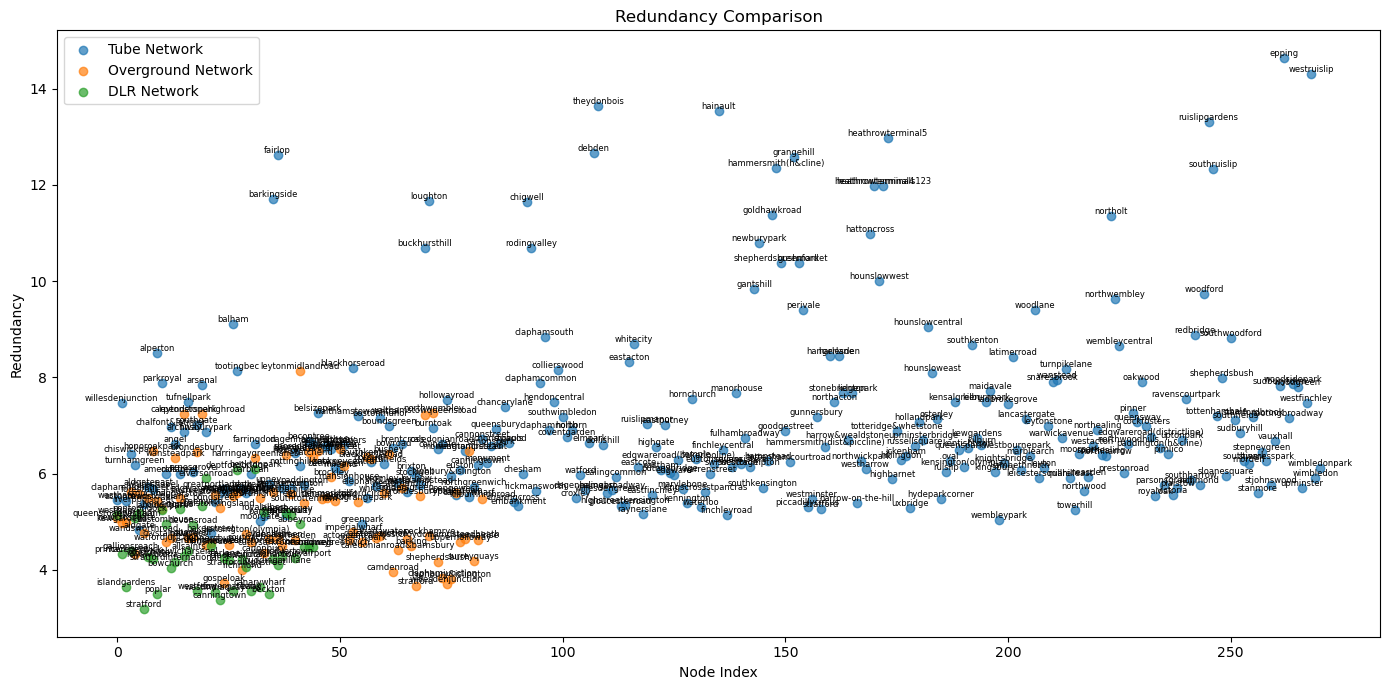

In [10]:
def calculate_redundancy(graph):
    redundancy = {}
    for node in graph.nodes():
        paths = nx.single_source_shortest_path(graph, node)
        total_paths = sum(len(paths[target]) for target in paths if target != node)
        redundancy[node] = total_paths / (len(graph.nodes()) - 1)
    return redundancy


redundancy_results = {}

for layer, graph in graphs.items():
    redundancy = calculate_redundancy(graph)
    redundancy_results[layer] = redundancy


for layer, data in redundancy_results.items():
    sorted_redundancy = sorted(data.items(), key=lambda x: x[1], reverse=True)
    top_redundancy_nodes = [node for node, red in sorted_redundancy[:3]]
    print(f"Network Layer: {layer}")
    print(f"Top Redundancy Nodes: {', '.join(top_redundancy_nodes)}")
    print()


plt.figure(figsize=(14, 7))

for layer, data in redundancy_results.items():
    redundancy_values = list(data.values())
    node_names = list(data.keys())
    plt.scatter(range(len(redundancy_values)), redundancy_values, label=f"{layer} Network", alpha=0.7)
    

    for i, name in enumerate(node_names):
        plt.text(i, redundancy_values[i], name, fontsize=6, ha='center', va='bottom')

plt.xlabel('Node Index')
plt.ylabel('Redundancy')
plt.title('Redundancy Comparison')
plt.legend()
plt.savefig("redun")
plt.tight_layout()
plt.show()

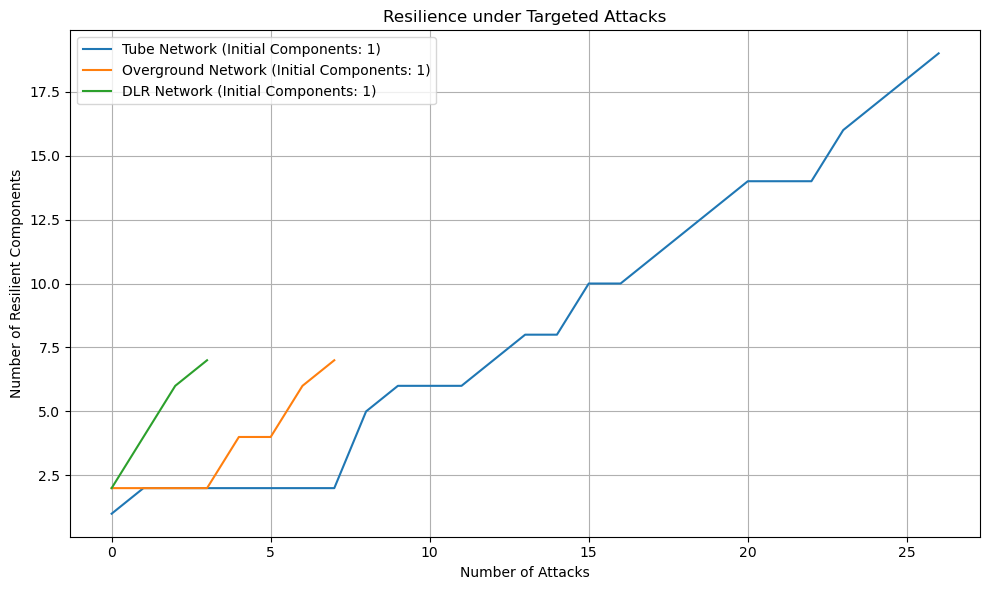

In [11]:
# Function to simulate targeted node attacks
def simulate_targeted_attacks(graph, num_attacks):
    resilient_components = []
    for _ in range(num_attacks):
        if len(graph.nodes()) > 1:
            node_to_remove = max(nx.degree_centrality(graph).items(), key=lambda x: x[1])[0]
            graph.remove_node(node_to_remove)
            resilient_components.append(nx.number_connected_components(graph))
    return resilient_components

# Function to plot resilience under argeted attacks
def plot_targeted_attacks_resilience(graphs):
    plt.figure(figsize=(10, 6))
    legend_labels = []

    for layer, graph in graphs.items():
        initial_components = nx.number_connected_components(graph)
        num_attacks = len(graph.nodes()) // 10  # Simulate attacking 10% of nodes
        resilient_components = simulate_targeted_attacks(graph.copy(), num_attacks)
        plt.plot(range(num_attacks), resilient_components, label=f"{layer} Network")
        legend_labels.append(f"{layer} Network (Initial Components: {initial_components})")

    plt.xlabel('Number of Attacks')
    plt.ylabel('Number of Resilient Components')
    plt.title('Resilience under Targeted Attacks')
    plt.legend(legend_labels)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("resilience")
    plt.show()

# Plot resilience under targeted attacks for each network layer
plot_targeted_attacks_resilience(graphs)


Top10 PageRank nodes for Tube Network:
Node: kingscrossstpancras,Score: 0.00991205180639482
Node: bakerstreet,Score: 0.009509930220265838
Node: camdentown,Score: 0.009384393685020113
Node: wembleypark,Score: 0.009092611548504284
Node: moorgate,Score: 0.009029285690531403
Node: earlscourt,Score: 0.008214776835173312
Node: paddington,Score: 0.008213033414575396
Node: actontown,Score: 0.007765668128677314
Node: turnhamgreen,Score: 0.007383293258100173
Node: liverpoolstreet,Score: 0.006633710953889872


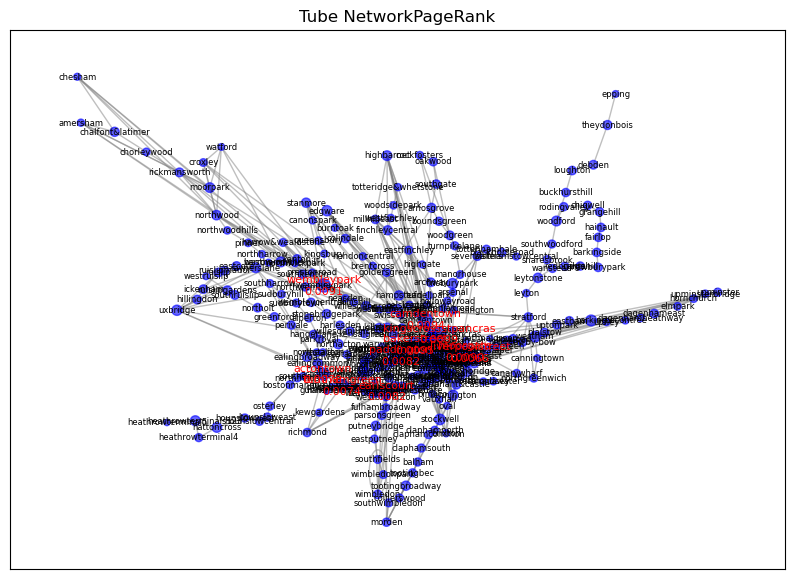

Top10 PageRank nodes for Overground Network:
Node: willesdenjunction,Score: 0.03723765678968944
Node: claphamjunction,Score: 0.026067639760039
Node: highbury&islington,Score: 0.02557294578219053
Node: gospeloak,Score: 0.023776459241747528
Node: surreyquays,Score: 0.02330469926174297
Node: richmond,Score: 0.022477524449581628
Node: sydenham,Score: 0.017286277351600383
Node: stratford,Score: 0.017054623224667616
Node: newcross,Score: 0.016499584797460533
Node: westcroydon,Score: 0.016370324550030797


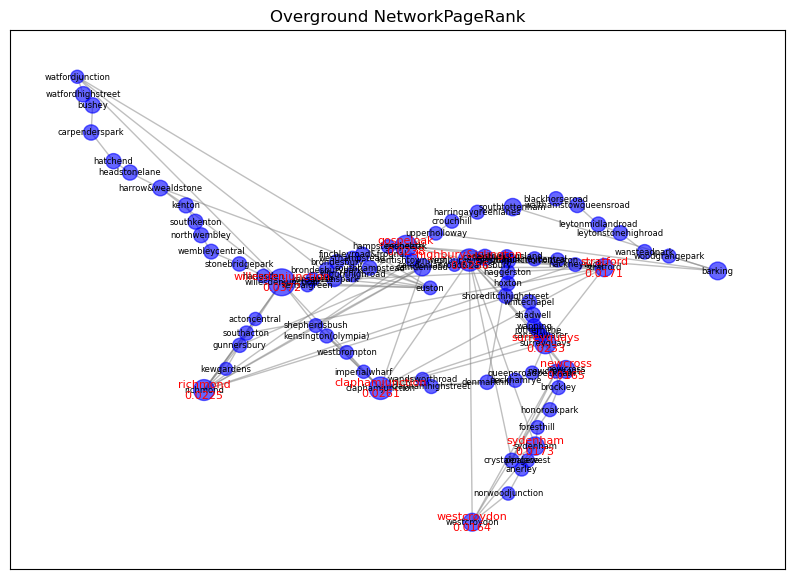

Top10 PageRank nodes for DLR Network:
Node: canningtown,Score: 0.0573133972484944
Node: stratford,Score: 0.04585549333749974
Node: poplar,Score: 0.04030485565899058
Node: beckton,Score: 0.033347869717797074
Node: westferry,Score: 0.031002563177176545
Node: westindiaquay,Score: 0.02719251346960534
Node: canarywharf,Score: 0.026769215559063586
Node: bowchurch,Score: 0.026351438711290066
Node: elversonroad,Score: 0.024072742783342514
Node: islandgardens,Score: 0.023990638372500192


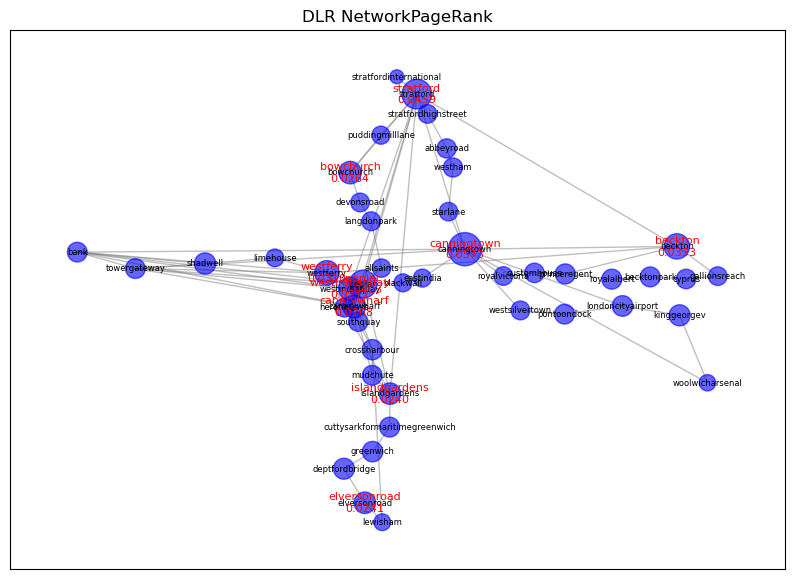

In [12]:
# Function to compute and print PageRank
def compute_pagerank(graph):
    pagerank_scores = nx.pagerank(graph, weight='weight')
    return pagerank_scores

# Function to visualize the graph with PageRank
def visualize_pagerank(graph,title,filename,top_nodes):
    pagerank_scores=compute_pagerank(graph)
    pos=nx.get_node_attributes(graph, 'pos')
    plt.figure(figsize=(10, 7))
    ax=plt.gca()
    
    nodes =nx.draw_networkx_nodes(graph,pos, node_size=[v*10000 for v in pagerank_scores.values()],node_color='blue',alpha=0.6,ax=ax)
    edges = nx.draw_networkx_edges(graph,pos, edge_color='grey',  alpha=0.5, ax=ax)
    labels = nx.draw_networkx_labels(graph,pos, font_size=6, ax=ax)
    top_nodes_labels= {node:f"{node}\n{pagerank_scores[node]:.4f}"for node in top_nodes}
    nx.draw_networkx_labels(graph,pos, labels=top_nodes_labels,font_size=8, font_color='red',ax=ax)
    plt.title(title)
    plt.savefig(filename,format='png')
    plt.show()

# Compute and visualize PageRank for each graph
for layer, graph in graphs.items():
    pagerank_scores= compute_pagerank(graph)
    sorted_pagerank = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)
    top10_nodes= sorted_pagerank[:10]   
    print(f"Top10 PageRank nodes for {layer} Network:")
    for node,score in top10_nodes:
        print(f"Node: {node},Score: {score}")
    
    top10_node_labels= [node for node, score in top10_nodes]
    visualize_pagerank(graph, f"{layer} NetworkPageRank",f"{layer}_network_pagerank.png", top10_node_labels)


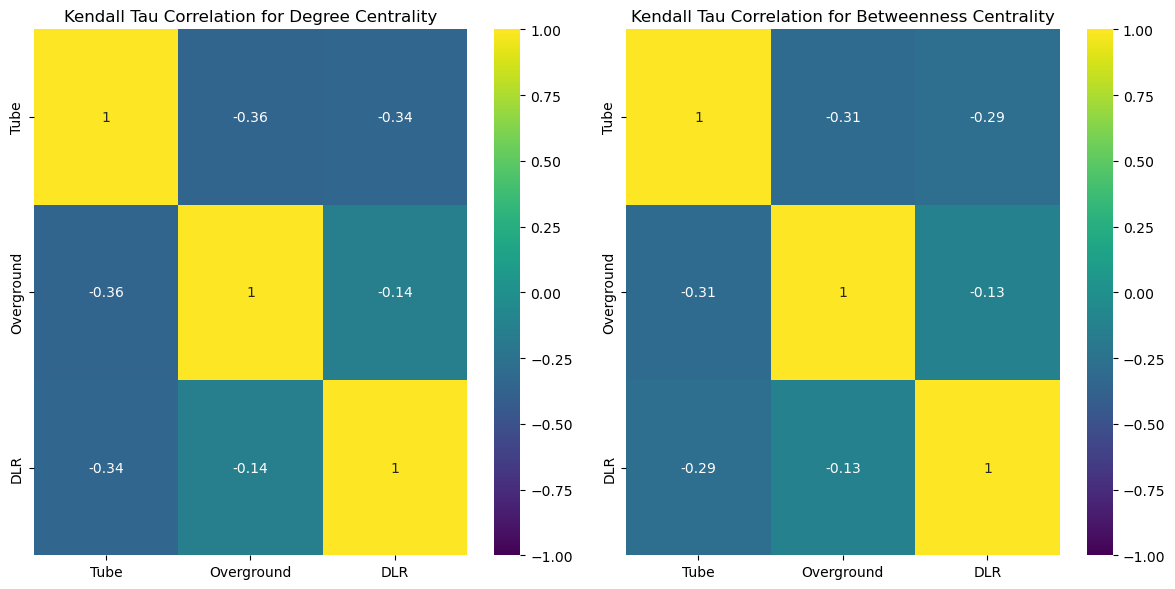

In [13]:
# Cal. centrality measures
centrality_measures = {}
for layer, graph in graphs.items():
    degree_centrality = nx.degree_centrality(graph)
    betweenness_centrality = nx.betweenness_centrality(graph)
    centrality_measures[layer] = {
        'degree': degree_centrality,
        'betweenness': betweenness_centrality
    }

# Create DataFrames for centrality measure
degree_dict = {layer: pd.Series(cent) for layer, cent_dict in centrality_measures.items() for cent_type, cent in cent_dict.items() if cent_type== 'degree'}
degree_df = pd.DataFrame(degree_dict).fillna(0)

betweenness_dict = {layer: pd.Series(cent) for layer, cent_dict in centrality_measures.items() for cent_type, cent in cent_dict.items() if cent_type =='betweenness'}
betweenness_df = pd.DataFrame(betweenness_dict).fillna(0)

# Function to cal. Kendall tau correlation matrix
def calculate_kendall_tau_corr(df):
    layers = df.columns
    corr_matrix = pd.DataFrame(index=layers, columns=layers, dtype=float)
    
    for i in layers:
        for j in layers:
            if i == j:
                corr_matrix.loc[i, j] = 1.0
            else:
                tau, _ = kendalltau(df[i], df[j])
                corr_matrix.loc[i, j] = tau
    
    return corr_matrix
# Compute Kendall tau correlation matrix
degree_corr = calculate_kendall_tau_corr(degree_df)
betweenness_corr = calculate_kendall_tau_corr(betweenness_df)

# Plotting the correlation matrix
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(degree_corr, annot=True, cmap='viridis', center=0, vmin=-1, vmax=1)
plt.title('Kendall Tau Correlation for Degree Centrality')

plt.subplot(1, 2, 2)
sns.heatmap(betweenness_corr, annot=True, cmap='viridis', center=0, vmin=-1, vmax=1)
plt.title('Kendall Tau Correlation for Betweenness Centrality')

plt.tight_layout()
plt.savefig('kendall_tau_correlation_centrality.png', format='png')
plt.show()
